# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [146]:
from __future__ import print_function

In [147]:
from IPython.display import Image

In [148]:
%matplotlib inline

In [149]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
%autoreload 2

In [151]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


#### Expect a environment variable ICDIR pointing to the IC root directory

In [152]:
ic = %env ICDIR

In [153]:
ic

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC'

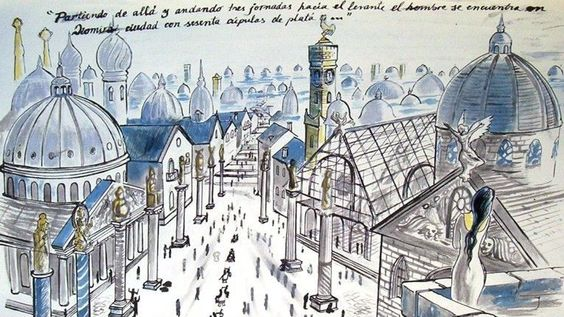

In [154]:
Image(filename=ic+'/Images/Diomira.jpg') 

## DIOMIRA notebook 

DIOMIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC

In [155]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [156]:
import matplotlib.pyplot as plt
import pandas as pd
import tables 
import numpy as np

In [157]:
from Configure import configure
from Nh5 import *

In [158]:
import mplFunctions as mpl
import wfmFunctions as wfm
from Util import *

In [159]:
import FEParam as FP
import SPE as SP
import FEE2 as FE

In [160]:
import cProfile

In [161]:
from scipy import sometrue

In [162]:
import scipy as sc

In [163]:
def simulate_sipm_response(event_number,sipmrd_):
    """
    For the moment use a dummy rutne that simply copies the sipm EARRAY
    """
    rdata = []

    for j in range(sipmrd_.shape[1]):
        rdata.append(sipmrd_[event_number, j])
    return np.array(rdata)


def simulate_pmt_response(event_number,pmtrd_):
    """
    Sensor Response
    Given a signal in PE (photoelectrons in bins of 1 ns) and the response function of 
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces the PMT raw data (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT
    pmtrd25 dataset to be created with adc counts, bins 25 ns 
    after convoluting with electronics
    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN) 
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
    
        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE) 

        #Signal out of DAQ
        #positive signal convention
        #signal_daq = fee.daqSignal(signal_fee, noise_rms=0) - FP.offset
        #negative signals convention!

        signal_daq = FP.offset -fee.daqSignal(signal_fee, noise_rms=0) 
    
        rdata.append(signal_daq)
    return np.array(rdata)


In [164]:
class FEE(tables.IsDescription):
    """
    Stores the parameters used by the EP simulation as metadata
    """
    
    offset = tables.Int16Col(pos=1)  #displaces the baseline (e.g, 700)
    pmt_gain =tables.Float32Col(pos=2)  #Gain of PMT (4.5e6)
    V_gain =tables.Float32Col(pos=3)  #FE gain (250*ohm)
    R = tables.Float32Col(pos=4) # resistor in Ohms (2350*ohm)
    C12 = tables.Float32Col(shape=12,pos=5) #6.2*nF  decoupling capacitor in pF
    AC = tables.Float32Col(shape=12,pos=6) #Accumulator coefficients
    time_step=tables.Float32Col(pos=7) #1*ns input MC time bins
    time_daq=tables.Float32Col(pos=8) #25*ns DAQ time 
    freq_LPF=tables.Float32Col(pos=9) #3E6*hertz
    freq_HPF=tables.Float32Col(pos=10) #1/2piRC
    LSB = tables.Float32Col(pos=11)    # Least Significant Bit 2*volt/2**NBITS, 
    volts_to_adc = tables.Float32Col(pos=12) # conversion from volts to adc counts
    noise_fee_rms = tables.Float32Col(pos=13) # noise FEE in volts
    noise_adc = tables.Float32Col(pos=14) # noise FEE in ADC counts

In [165]:
def FEE_param_table(fee_table):
    """
    Stores the parameters of the EP FEE simulation 
    """
    row = fee_table.row
    row['offset'] = FP.offset
    row['pmt_gain'] = FP.PMT_GAIN
    row['V_gain'] = FP.V_GAIN
    row['R'] = FP.R
    row['C12'] = FP.C12
    row['AC'] = FP.AC 
    row['time_step'] = FP.time_step
    row['time_daq'] = FP.time_DAQ
    row['freq_LPF'] = FP.freq_LPF
    row['freq_HPF'] = 1./(2*pi*FP.R*FP.C)
    row['LSB'] = FP.LSB
    row['volts_to_adc'] = FP.voltsToAdc/volt
    row['noise_fee_rms'] = FP.NOISE_FEE
    row['noise_adc'] = FP.NOISE_ADC
    
    row.append()

In [166]:
class TWF(tables.IsDescription):
    event = tables.UInt32Col(pos=0)
    pmt = tables.UInt32Col(pos=1)
    time_ns = tables.Float32Col(pos=2)
    ene_pes = tables.Float32Col(pos=3)

In [167]:
def store_twf(event, table, TWF):
    """
    Store TWF in table
    """
    row = table.row
    for ipmt in range(len(TWF)):
        twf = TWF[ipmt]
        for i in range(len(twf)):
            row['event'] = event
            row['pmt'] = ipmt
            row['time_ns'] = twf.time_ns[i]
            row['ene_pes'] = twf.ene_pes[i]
            row.append()
    table.flush()

#### DIOMIRA.py

In [168]:
"""
ChangeLog:

26.9 

Changed types of PMTRWF, SIPMRWF and PMTTWF to Float32 for 
    (compatibility with ART/GATE)

Do not store EPMT and ESIPM (can be computed on the fly)

Change sign of pmtrwf to negative (as produced by the DAQ)
"""

def DIOMIRA(argv):
    DEBUG_LEVEL, INFO, CYTHON, CFP = configure(argv[0],argv[1:])
   
    if INFO:
        
        print("""
        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        """)
        FP.print_FEE()

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    NEVENTS = LAST_EVT - FIRST_EVT

    print('Debug level = {}'.format(DEBUG_LEVEL))

    print("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    print("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    print("Compression library = {} Compression level = {} ".format(
        CLIB,CLEVEL))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r+") as h5in: 
        # access the PMT raw data in file 

        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)
        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        print("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        print("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))

        #wait()

        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        
        # open the output file 
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib=CLIB, complevel=CLEVEL)) as h5out:
 
            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",tables.Filters(0))
            
            
            # create a group to store True waveform data
            twfgroup = h5out.create_group(h5out.root, "TWF")
                                          
            # create a table to store true waveform (zs, rebinned)
            twf_table = h5out.create_table(twfgroup, "TWF", TWF, "Store for TWF",
                                tables.Filters(complib=CLIB, complevel=CLEVEL))

            # fill FEE table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")
            
            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            
            
            # create an extensible array to store the TWF waveforms
#             pmttwf = h5out.create_earray(h5out.root.RD, "pmttwf", 
#                                     atom=tables.Float32Atom(), 
#                                     shape=(0, NPMT, PMTWL_FEE), 
#                                     expectedrows=NEVENTS_DST)
            

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NSIPM, SIPMWL), 
                                    expectedrows=NEVENTS_DST)

            # #create an extensible array to store the energy in PES of PMTs 
            # epmt = h5out.create_earray(h5out.root.RD, "epmt", 
            #                         atom=tables.FloatAtom(), 
            #                         shape=(0, NPMT), 
            #                         expectedrows=NEVENTS_DST)

            # # create an extensible array to store the energy in PES of SiPMs 
            # esipm = h5out.create_earray(h5out.root.RD, "esipm", 
            #                         atom=tables.FloatAtom(), 
            #                         shape=(0, NSIPM), 
            #                         expectedrows=NEVENTS_DST)

            
            if NEVENTS > NEVENTS_DST and RUN_ALL == False:
                print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
                sys.exit(0)
            elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
                FIRST_EVT = 0
                LAST_EVT = NEVENTS_DST
                NEVENTS = NEVENTS_DST


            for i in range(FIRST_EVT,LAST_EVT):
                print("-->event number ={}".format(i))
                
                #truePMT = rebin_signal(i,pmtrd_, int(FP.time_DAQ))
                rebin = int(1*mus/1*ns)
                truePMT = twf_signal(i,pmtrd_, rebin)
                
                
                store_twf(i, twf_table, truePMT)
                
                #truePMT.astype(float)

                #simulate PMT response and return an array with RWF
                dataPMT = simulate_pmt_response(i,pmtrd_)

                #convert to float
                dataPMT.astype(float) 
            
                
                #logger.info("truePMT shape ={}".format(truePMT.shape))
                #logger.info("dataPMT shape ={}".format(dataPMT.shape))
                
                #RWF for pmts
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))
                
                
                #TWF for pmts
                #pmttwf.append(truePMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                   
                #simulate SiPM response and return an array with new WF
                dataSiPM = simulate_sipm_response(i,sipmrd_)
                dataSiPM.astype(float)
                
                #append to SiPM EARRAY
                sipmrwf.append(dataSiPM.reshape(1, NSIPM, SIPMWL))

                # #fill ene_pmt vector
                # enePMT = energy_pes(i, pmtrd_)
                # #append to epmt EARRAY
                # epmt.append(enePMT.reshape(1, NPMT))

                # #fill ene_sipm vector
                # eneSIPM = energy_pes(i, sipmrd_)
                # esipm.append(eneSIPM.reshape(1, NSIPM))

            pmtrwf.flush()
            #pmttwf.flush()
            sipmrwf.flush()
            #epmt.flush()
            #esipm.flush()


    print("Leaving Diomira. Safe travels!")


In [172]:
def twf_signal(event_number,pmtrd, stride):
    """
    rebins the MCRD signal to produce TWF (pes, bins 25 ns)
    """
    
    rdata = []

    for j in range(pmtrd.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        energy_pes = pmtrd[event_number, j] #waveform for event event_number, PMT j
        time_ns = np.array(range(pmtrd.shape[2]))
        twf_zs = wf_thr(wfdf(time_ns,energy_pes),0.5)
        time_ns, ene_pes = rebin_twf(twf_zs.time_ns.values,twf_zs.ene_pes.values,stride)
        twf = wfdf(time_ns, ene_pes)
        logger.debug("-->len(twf) ={}".format(len(twf)))
        #print(twf)
        
        rdata.append(twf)
    return rdata




In [170]:
def plot_pmtwf(PMTWF):
    """
    Plots pmtwf
    """
    
    plt.figure(figsize=(12,12))
    for i in range(0,len(PMTWF)):
        ax1 = plt.subplot(3,4,i+1)
        pmtwf = PMTWF[i]
        plt.plot(pmtwf['time_ns']/mus,pmtwf['ene_pes'])
    
    plt.show()

In [171]:

def wfdf(time_ns,energy_pes):
    """
    takes two vectors (time, energy) and returns a data frame representing a waveform
    """
    swf = {}
    swf['time_ns'] = time_ns
    swf['ene_pes'] = energy_pes 
    return pd.DataFrame(swf)

def wf_thr(wf,threshold=1):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]

def rebin_twf(t, e, stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    n = len(t)/int(stride)
    r = len(t)%int(stride)
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    T = np.zeros(lenb,dtype=np.float32)
    E = np.zeros(lenb,dtype=np.float32)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        j+= stride
        
    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])
    
    return T,E
    
   

### Configuration file

In [144]:
%less ../../Config/DIOMIRA_NA_ZLIB_test2.csv

#### Running the script

In [173]:
%time DIOMIRA(['DIOMIRA','-i','-d','INFO','-c''../../Config/DIOMIRA_NA_ZLIB_test2.csv'])


        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        

  NEW FEE: DEFAULT PARAMETERS
  PMT gain = 4.5e+06
  sampling time: (fine) =    1.00 ns (DAQ) =   25.00 ns 
  decoupling capacitor =    6.20 nF
  decoupling resistor = 2350.00 ohm
  HPF frequency = 10923.47 Hz  W_HPF_fine = 1.1e-05 W_HPF_daq = 0.00027 
  LPF frequency

### cython version

In [212]:
%%cython
import numpy as np
cimport numpy as np
def rebin_twf_cy(int[:] t, int[:] e, int stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    cdef int n, r
    n = len(t)/stride
    r = len(t)%stride
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    cdef float [:] T = np.zeros(lenb,dtype=np.float32)
    cdef float [:] E = np.zeros(lenb,dtype=np.float32)
    
    cdef int i,j,k
    j=0
    cdef float sum_e, sum_t
    
    #for i in range(n):
    #   E[i] = np.sum(e[j:j+stride])
    #   T[i] = np.mean(t[j:j+stride])
    #   j+= stride
        
    j=0
    for i in range(n):
        sum_e = 0.
        sum_t = 0.
        for k in range(j, j + stride): 
            sum_e += e[k]
            sum_t += t[k]
        E[i] = sum_e
        T[i] = sum_t
        j+= stride
        
    if r > 0:
        sum_e = 0.
        sum_t = 0.
        for k in range(n, lenb): 
            sum_e += e[k]
            sum_t += t[k]
        E[n] = sum_e
        T[n] = sum_t
        
    
    return np.asarray(T),np.asarray(E)
    
    #return T,E
    

In [210]:
def twf_signal(event_number,pmtrd, stride):
    """
    rebins the MCRD signal to produce TWF (pes, bins 25 ns)
    """
    
    rdata = []

    for j in range(pmtrd.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        energy_pes = pmtrd[event_number, j] #waveform for event event_number, PMT j
        time_ns = np.array(range(pmtrd.shape[2]), dtype=np.int32)
        twf_zs = wf_thr(wfdf(time_ns,energy_pes),0.5)
        #print(twf_zs.time_ns.values.dtype)
        #print(twf_zs.ene_pes.values.dtype)
        #print(type(stride))
        time_ns, ene_pes = rebin_twf_cy(twf_zs.time_ns.values,twf_zs.ene_pes.values,stride)
        #print(time_ns.dtype)
        #print(ene_pes.dtype)
        twf = wfdf(time_ns, ene_pes)
        logger.debug("-->len(twf) ={}".format(len(twf)))
        #print(twf)
        
        rdata.append(twf)
    return rdata




In [213]:
%time DIOMIRA(['DIOMIRA','-i','-d','INFO','-c''../../Config/DIOMIRA_NA_ZLIB_test2.csv'])


        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        

  NEW FEE: DEFAULT PARAMETERS
  PMT gain = 4.5e+06
  sampling time: (fine) =    1.00 ns (DAQ) =   25.00 ns 
  decoupling capacitor =    6.20 nF
  decoupling resistor = 2350.00 ohm
  HPF frequency = 10923.47 Hz  W_HPF_fine = 1.1e-05 W_HPF_daq = 0.00027 
  LPF frequency

*There is a small improvement but not enough to justify using cython (unless we attack also other functions)*

In [214]:
cProfile.run("DIOMIRA(['DIOMIRA','-i','-d','INFO','-c''../../Config/DIOMIRA_NA_ZLIB_test2.csv'])",sort='time')


        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        

  NEW FEE: DEFAULT PARAMETERS
  PMT gain = 4.5e+06
  sampling time: (fine) =    1.00 ns (DAQ) =   25.00 ns 
  decoupling capacitor =    6.20 nF
  decoupling resistor = 2350.00 ohm
  HPF frequency = 10923.47 Hz  W_HPF_fine = 1.1e-05 W_HPF_daq = 0.00027 
  LPF frequency

### Checking the file

In [88]:
%ls -lh '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_twf10_RWF.h5'

-rw-r--r--  1 jjgomezcadenas  staff    10M Sep 29 10:23 /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_twf10_RWF.h5


In [89]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_twf10_RWF.h5')

In [90]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_twf10_RWF.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float64Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float64Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float64Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float64Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (1170,)
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "offset": Int16Col(shape=(), dflt=0, pos=0),
  "pmt_gain": Float32Col(shape=(), dflt=0.0, pos=1),
  "V_gain": Float32Col(shape=(), dflt=0.0, pos=2),
  "R": Float32Col(shape=(), dflt=0.0, pos=3),
  "C12": Float32Col(shape=(12,), dflt=0.0, pos=4),
  "AC": Float32Col(shape=(12,), dflt=0.0, pos=5),
  "time_step": Float32Col

In [91]:
pmtrwf = h5f.root.RD.pmtrwf

In [92]:
pmtr0 = pmtrwf[0,0]

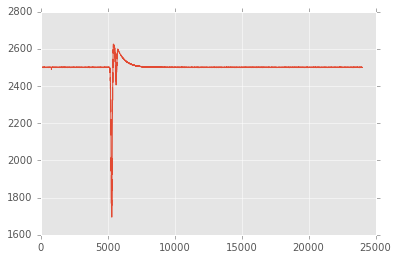

In [93]:
plt.plot(pmtr0)

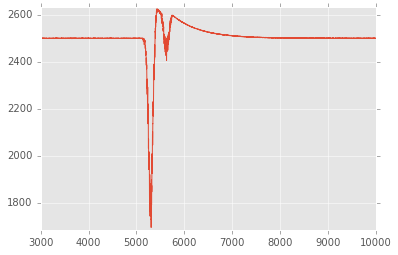

In [95]:
mpl.plts(pmtr0, signal_start=3000, signal_end=10000, offset=10)

In [96]:
sgn = 4096 - pmtr0

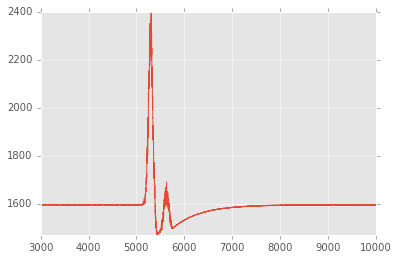

In [97]:
mpl.plts(sgn, signal_start=3000, signal_end=10000, offset=0)

In [98]:
sgnzs = sgn -1600

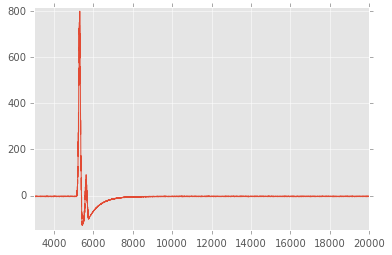

In [100]:
mpl.plts(sgnzs, signal_start=3000, signal_end=20000, offset=20)

In [104]:
h5f.close()

In [118]:
def read_twf(filepath, event_number):
    """
    Reads back the TWF
    """
    with tables.open_file(filepath, "r+") as h5f:
    
        table = h5f.root.TWF.TWF
        PMT={}
        for row in table.where("event == event_number"):
            pmt = row['pmt']
            time_ns = row['time_ns'] 
            ene_pes =  row['ene_pes']
        
            if pmt not in PMT:
                WF={}
                TIME =[]
                ENE = []
                TIME.append(time_ns)
                ENE.append(ene_pes)
                WF['time_ns'] = TIME
                WF['ene_pes'] = ENE
                PMT[pmt] = WF
            else:
                WF = PMT[pmt]
                TIME = WF['time_ns']
                ENE  = WF['ene_pes']
                TIME.append(time_ns)
                ENE.append(ene_pes)
                
    return PMT

In [105]:
fpath= '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_twf10_RWF.h5'

In [119]:
TWF = read_twf(fpath, 0)

In [120]:
TWF

{0L: {'ene_pes': [1526.0, 2011.0, 1428.0, 960.0],
  'time_ns': [130813.9609375, 132510.5, 134208.40625, 140837.328125]},
 1L: {'ene_pes': [1535.0, 1999.0, 1488.0, 954.0],
  'time_ns': [130947.578125, 132521.171875, 134017.484375, 140815.890625]},
 2L: {'ene_pes': [1504.0, 1993.0, 1458.0, 950.0],
  'time_ns': [130593.6796875, 132508.40625, 134103.53125, 140811.609375]},
 3L: {'ene_pes': [1411.0, 1795.0, 1279.0, 568.0],
  'time_ns': [130858.0234375, 132640.296875, 135673.5625, 141447.734375]},
 4L: {'ene_pes': [1465.0, 1809.0, 1262.0, 525.0],
  'time_ns': [130558.6328125, 132680.78125, 135749.75, 141516.421875]},
 5L: {'ene_pes': [1441.0, 1797.0, 1234.0, 553.0],
  'time_ns': [131031.421875, 132690.09375, 135759.21875, 141425.5625]},
 6L: {'ene_pes': [1419.0, 1820.0, 1310.0, 558.0],
  'time_ns': [130844.5234375, 132604.5, 135571.3125, 141431.15625]},
 7L: {'ene_pes': [1490.0, 1793.0, 1262.0, 555.0],
  'time_ns': [131103.859375, 132658.921875, 135738.25, 141414.6875]},
 8L: {'ene_pes': [14

In [131]:
def twf_df(TWF_DICT):
    PMT = []
    for indx in TWF_DICT:
        pmt = TWF_DICT[indx]
        print(pmt)
        PMT.append(pd.DataFrame(pmt))
    return PMT
    

In [132]:
twfdf = twf_df(TWF)

{'time_ns': [130813.9609375, 132510.5, 134208.40625, 140837.328125], 'ene_pes': [1526.0, 2011.0, 1428.0, 960.0]}
{'time_ns': [130947.578125, 132521.171875, 134017.484375, 140815.890625], 'ene_pes': [1535.0, 1999.0, 1488.0, 954.0]}
{'time_ns': [130593.6796875, 132508.40625, 134103.53125, 140811.609375], 'ene_pes': [1504.0, 1993.0, 1458.0, 950.0]}
{'time_ns': [130858.0234375, 132640.296875, 135673.5625, 141447.734375], 'ene_pes': [1411.0, 1795.0, 1279.0, 568.0]}
{'time_ns': [130558.6328125, 132680.78125, 135749.75, 141516.421875], 'ene_pes': [1465.0, 1809.0, 1262.0, 525.0]}
{'time_ns': [131031.421875, 132690.09375, 135759.21875, 141425.5625], 'ene_pes': [1441.0, 1797.0, 1234.0, 553.0]}
{'time_ns': [130844.5234375, 132604.5, 135571.3125, 141431.15625], 'ene_pes': [1419.0, 1820.0, 1310.0, 558.0]}
{'time_ns': [131103.859375, 132658.921875, 135738.25, 141414.6875], 'ene_pes': [1490.0, 1793.0, 1262.0, 555.0]}
{'time_ns': [130935.1328125, 132722.3125, 135893.078125, 141410.171875], 'ene_pes': 

In [135]:
twfdf[0]

,ene_pes,time_ns
0,1526.0,130813.960938
1,2011.0,132510.500000
2,1428.0,134208.406250
3,960.0,140837.328125


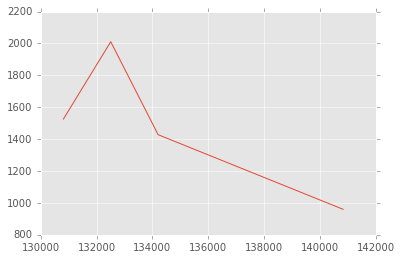

In [136]:
plt.plot(twfdf[0].time_ns,twfdf[0].ene_pes)

In [137]:
np.sum(twfdf[0].ene_pes)

5925.0

In [138]:
h5f.close()